In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.mixed_linear_model import MixedLM
import pingouin as pg

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice

plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figdir = "C:/Users/esay/data/YMazeResults/downsample/reward_overrep"
os.makedirs(figdir, exist_ok = True)

In [3]:
df = pd.DataFrame({'mouse':[],
                                'ko':[],
                                'day':[], 
                                'lr':[], 
                                'novfam':[], 
                                'frac': [], 
                                })



In [58]:
class LMM_PeriRewardPlaceCellFrac:

    def __init__(self, days = np.arange(6), ts_key = 'spks'):

        '''


        :param days:
        :param ts_key:
        '''

        self.ko_mice = stx.ymaze_sess_deets.ko_mice
        self.ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
        self.__dict__.update({'days': days, 'ts_key': ts_key})
        self.n_days = days.shape[0]

        self.df = pd.DataFrame({'mouse':[],
                                'ko':[],
                                'day':[], 
                                'lr':[], 
                                'novfam':[], 
                                'frac': [], 
                                })
        self.fill_df()
        

    def fill_df(self):
        for m, mouse in enumerate(self.ctrl_mice):
            for day in self.days:
                self.argmax_perireward(u.load_single_day_noconcat(mouse,day),m,0,day)
                
        for m, mouse in enumerate(self.ko_mice):
            for day in self.days:
                self.argmax_perireward(u.load_single_day_noconcat(mouse, day),m+len(self.ctrl_mice), 1,day)
                
        
                
                
                

    def argmax_perireward(self, sess, m, ko, day, ts_key: str = 'spks'):
        '''

        :param sess:
        :param ts_key:
        :param fam:
        :return:
        '''

        
        trials_mat = sess.trial_matrices[ts_key]
        bin_edges = sess.trial_matrices['bin_edges']
        downsample_mask = sess.trial_matrices['downsample']
        
        for _arm, arm in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']==arm & downsample_mask
            if sess.novel_arm == arm:
                cell_mask = sess.nov_place_cell_mask()
                rzone_front = np.argwhere((sess.rzone_nov['tfront'] <= bin_edges[1:]) * \
                                          (sess.rzone_nov['tfront'] >= bin_edges[:-1]))[0][0]
                nov = 'nov'
            else:
                cell_mask = sess.fam_place_cell_mask()
                rzone_front = np.argwhere((sess.rzone_fam['tfront'] <= bin_edges[1:]) * \
                                          (sess.rzone_fam['tfront'] >= bin_edges[:-1]))[0][0]
                nov = 'fam'



            # smooth ratemap by 1 bin
            ratemap = sp.ndimage.gaussian_filter1d(np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0)
            max_inds = np.argmax(ratemap[:,cell_mask], axis = 0) - rzone_front
            reward_frac = self.get_frac(max_inds)
            
            self.df = pd.concat((self.df, pd.DataFrame({'mouse': sess.mouse, 
                                     'ko': ko, 
                                     'day': day,
                                     'lr': _arm, 
                                     'novfam': nov, 
                                     'frac': reward_frac,},
                                    index=[len(self.df)])), ignore_index=True)
            
        

    @staticmethod
    def get_frac(data):
        '''

        :param frac:
        :return:
        '''
        x = np.arange(-30, 15)
        anova_mask = (x >= -5) * (x <= -1)

        hist = np.array([np.count_nonzero(data.ravel() == _bin) for _bin in x.tolist()])
        hist = hist / hist.sum()
        return hist[anova_mask].sum() / hist[~anova_mask].sum()

    

In [60]:
lmm_frac = LMM_PeriRewardPlaceCellFrac()

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_57820\1180033680.py:71: RuntimeWarning: Mean of empty slice
  ratemap = sp.ndimage.gaussian_filter1d(np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0)
C:\Users\esay\AppData\Local\Temp\ipykernel_57820\1180033680.py:71: RuntimeWarning: Mean of empty slice
  ratemap = sp.ndimage.gaussian_filter1d(np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0)


{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_57820\1180033680.py:71: RuntimeWarning: Mean of empty slice
  ratemap = sp.ndimage.gaussian_filter1d(np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0)
C:\Users\esay\AppData\Local\Temp\ipykernel_57820\1180033680.py:71: RuntimeWarning: Mean of empty slice
  ratemap = sp.ndimage.gaussian_filter1d(np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0)


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 

c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

In [61]:
lmm_frac.df.to_pickle("C:/Users/esay/data/Stx3/downsample_speed/df_rewardfrac.pkl")

In [62]:
res = pg.mixed_anova(data = lmm_frac.df[lmm_frac.df['novfam']=='nov'], dv= 'frac', between = 'ko', within = 'day', subject = 'mouse')
print(res)

posthoc = pg.pairwise_tests(data = lmm_frac.df[lmm_frac.df['novfam']=='nov'], dv= 'frac', between = 'ko', within = 'day', subject = 'mouse', padjust='holm',parametric = False)
print(posthoc)



        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.006611    1   14  0.006611  0.681839  0.422803  0.046441   
1          day  0.013913    5   70  0.002783  1.064840  0.387318  0.070684   
2  Interaction  0.012945    5   70  0.002589  0.990745  0.429771  0.066090   

        eps  
0       NaN  
1  0.475614  
2       NaN  
    Contrast  day    A    B Paired  Parametric  U-val  W-val alternative  \
0        day    -  0.0  1.0   True       False    NaN   47.0   two-sided   
1        day    -  0.0  2.0   True       False    NaN   56.0   two-sided   
2        day    -  0.0  3.0   True       False    NaN   28.0   two-sided   
3        day    -  0.0  4.0   True       False    NaN   35.0   two-sided   
4        day    -  0.0  5.0   True       False    NaN   58.0   two-sided   
5        day    -  1.0  2.0   True       False    NaN   67.0   two-sided   
6        day    -  1.0  3.0   True       False    NaN   39.0   two-sided   
7        day    -  1.0 

In [63]:
res = pg.mixed_anova(data = lmm_frac.df[lmm_frac.df['novfam']=='fam'], dv= 'frac', between = 'ko', within = 'day', subject = 'mouse')
print(res)

posthoc = pg.pairwise_ttests(data = lmm_frac.df[lmm_frac.df['novfam']=='fam'], dv= 'frac', between = 'ko', within = 'day', subject = 'mouse', padjust='holm',parametric = False)
print(posthoc)



        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.017238    1   14  0.017238  0.672903  0.425788  0.045860   
1          day  0.008247    5   70  0.001649  0.965948  0.444702  0.064543   
2  Interaction  0.009087    5   70  0.001817  1.064334  0.387597  0.070653   

        eps  
0       NaN  
1  0.579134  
2       NaN  
    Contrast  day    A    B Paired  Parametric  U-val  W-val alternative  \
0        day    -  0.0  1.0   True       False    NaN   68.0   two-sided   
1        day    -  0.0  2.0   True       False    NaN   46.0   two-sided   
2        day    -  0.0  3.0   True       False    NaN   35.0   two-sided   
3        day    -  0.0  4.0   True       False    NaN   43.0   two-sided   
4        day    -  0.0  5.0   True       False    NaN   61.0   two-sided   
5        day    -  1.0  2.0   True       False    NaN   32.0   two-sided   
6        day    -  1.0  3.0   True       False    NaN   29.0   two-sided   
7        day    -  1.0 

C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


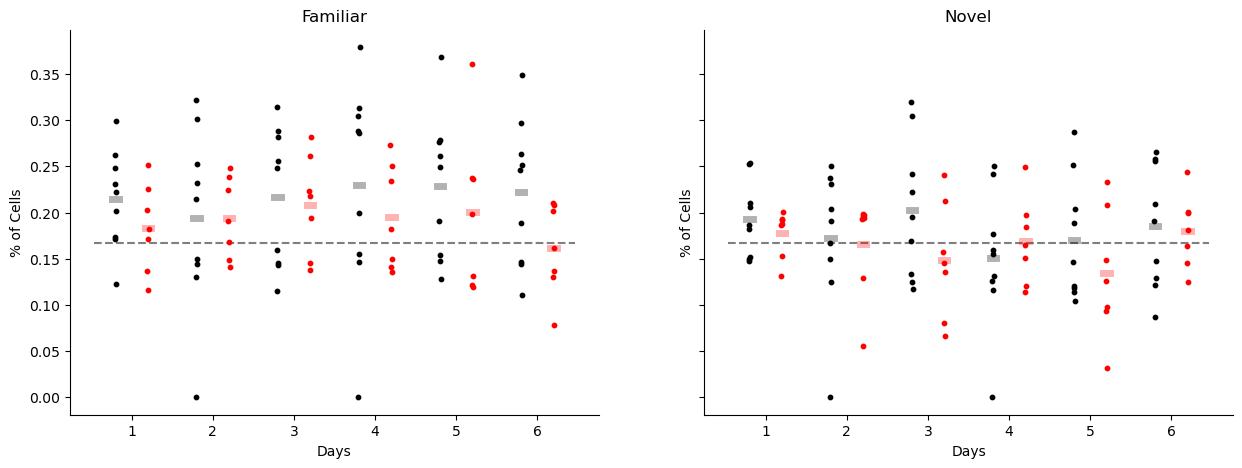

In [64]:
fig, ax = plt.subplots(1,2,figsize = [15,5], sharey=True)
s = 10
lw = 5
for day in range(6):
    mask = (lmm_frac.df['ko']==0) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='fam')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax[0].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), frac, color = 'black', s=s)
    ax[0].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['ko']==0) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='nov')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax[1].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), frac, color = 'black', s=s, alpha = 1)
    ax[1].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['ko']==1) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='fam')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax[0].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ko_mice)), frac, color = 'red', s=s)
    ax[0].plot(5*day  +1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth =lw, alpha = .3)
    
    mask = (lmm_frac.df['ko']==1) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']=='nov')
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax[1].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ko_mice)), frac, color = 'red', s=s, alpha = 1)
    ax[1].plot(5*day +1+ np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    
    ax[0].set_title('Familiar')
    ax[1].set_title('Novel')

    # what is this dotted line? idk 
ax[0].plot([-2.3, 27.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
ax[1].plot([-2.3, 27.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("% of Cells")
    ax[a].set_xticks(5*np.arange(6))
    ax[a].set_xticklabels(np.arange(1,7))
# fig.savefig(os.path.join(figdir, 'reward_frac_summary.pdf'))

3.0167599069422897 0.0025549208585910156


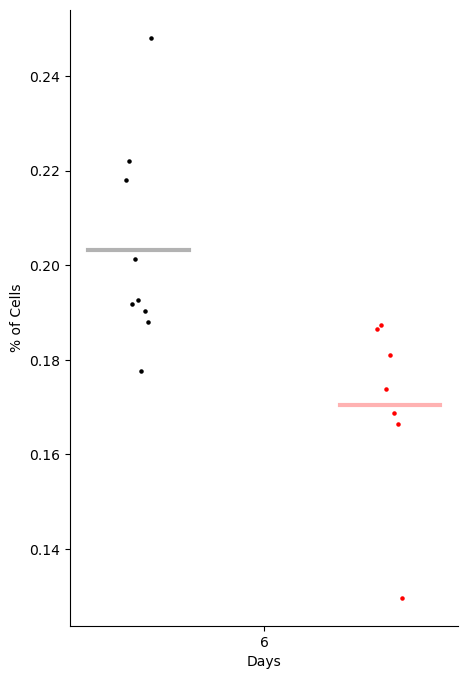

In [72]:
fig, ax = plt.subplots(figsize=[5,8])

for day in [5]: #range(5,6):
    mask = (lmm_frac.df['ko']==0) & (lmm_frac.df['day']==day) #& (lmm_frac.df['novfam']==0)
    ctrl_frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax.scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), ctrl_frac, color = 'black', s=5)
    ax.plot(5*day  -.5 + np.array([-0.2,0.2]), ctrl_frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    
    mask = (lmm_frac.df['ko']==1) & (lmm_frac.df['day']==day) #& (lmm_frac.df['novfam']==0)
    ko_frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax.scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(ko_mice)), ko_frac, color = 'red', s=5)
    ax.plot(5*day  +.5 + np.array([-0.2,0.2]), ko_frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("% of Cells")
ax.set_xticks(5*np.arange(5,6))
ax.set_xticklabels(np.arange(6,7))

# ax.plot([23.7, 26.3], 5/30*np.ones((2,)), 'k--', zorder= -1, alpha=.5)
    
t,p = sp.stats.ranksums(ctrl_frac,ko_frac)
# t,p = sp.stats.wilcoxon(ko_frac-4/30)
print(t,p)
# fig.savefig(os.path.join(figdir, "reward_pc_frac_summary_short.pdf"))

In [67]:
fam_pc_fracs = stx.reward_overrep.PeriRewardPlaceCellFrac(fam=True, days = np.arange(6))

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel'

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:217: RuntimeWarning: divide by zero encountered in scalar divide
  return fig, ax


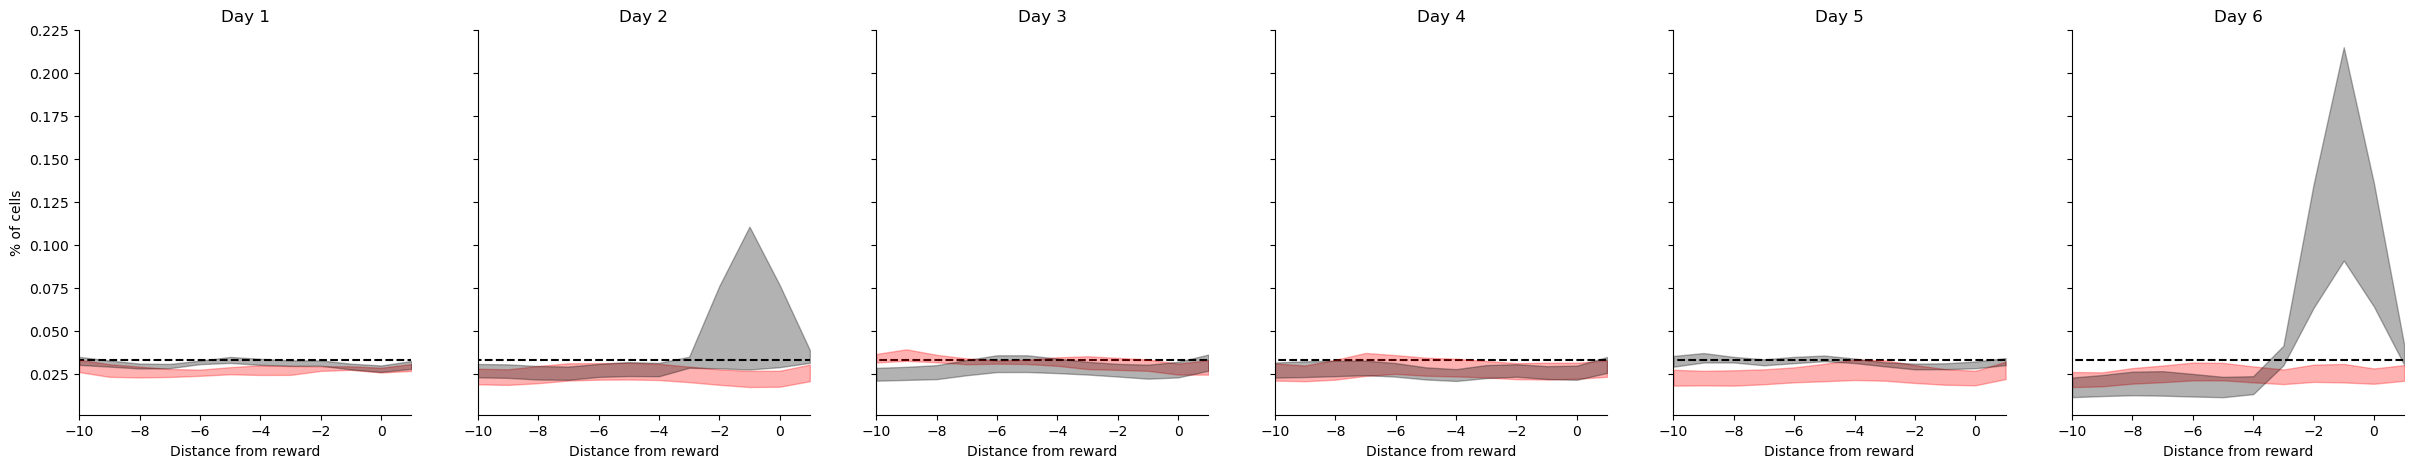

In [68]:
fig,ax = fam_pc_fracs.perireward_hist()
# fig.savefig(os.path.join(figdir,'fam_placecell_frac_perireward.pdf'),format='pdf')

In [32]:
nov_pc_fracs = stx.reward_overrep.PeriRewardPlaceCellFrac(fam=False)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 's

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 

c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', '

c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:184: RuntimeWarning: Mean of empty slice
  hist = hist / hist.sum()


{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\stx3ko_analyses\STX3KO_analyses\reward_overrep.py:217: RuntimeWarning: divide by zero encountered in scalar divide
  return fig, ax


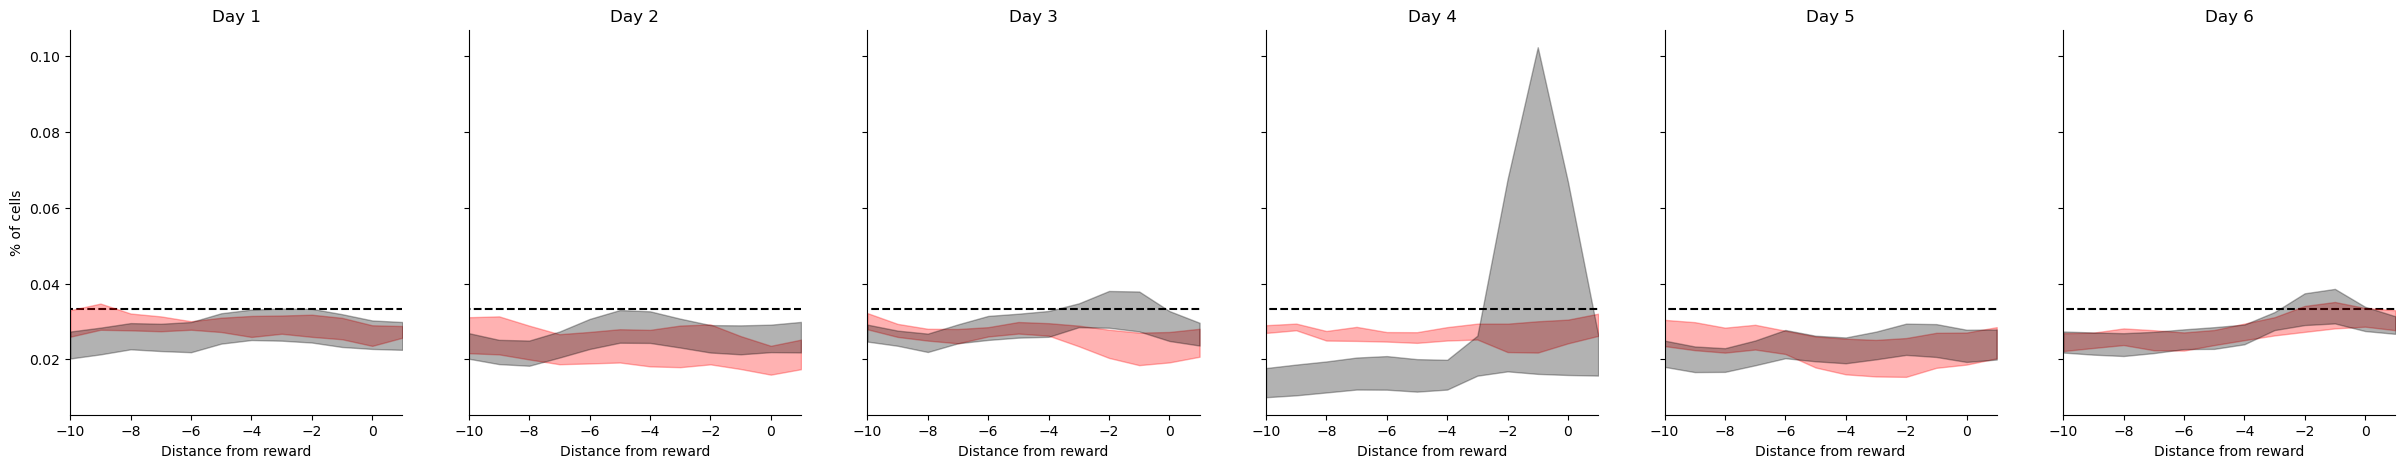

In [33]:
fig,ax = nov_pc_fracs.perireward_hist()
# fig.savefig(os.path.join(figdir,"nov_placecell_frac_perireward.pdf"),format = 'pdf')


In [38]:
def get_smooth_hist(max1, max2,bins = np.arange(0,30)):
    hist, xedges, yedges = np.histogram2d(max1,max2, bins = [bins, bins], density = True)
    hist_sm = sp.ndimage.gaussian_filter(hist, (1,1))
    hist_sm /= hist_sm.ravel().sum()
    return hist_sm


def _get_lr_map(sess):
    
    left_mask = sess.trial_info['LR']==-1
    pc_mask = np.zeros([sess.trial_matrices['spks_norm'].shape[-1],])
    downsample_mask = sess.trial_matrices['downsample']
    left_mask = left_mask & downsample_mask
    right_mask = ~left_mask & downsample_mask
    
    for key in sess.place_cell_info.keys():
        if len(sess.place_cell_info[key]['masks'].shape)>1:
            pc_mask += 1*sess.place_cell_info[key]['masks'].sum(axis=0)
        else:
            pc_mask += 1*sess.place_cell_info[key]['masks']
    pc_mask = pc_mask>0
    
    return np.nanmean(sess.trial_matrices['spks_norm'][left_mask,1:-1,:],axis=0)[:,pc_mask], np.nanmean(sess.trial_matrices['spks_norm'][~right_mask,1:-1,:],axis=0)[:,pc_mask]
  
def get_lr_maps(mice):
    left_mats, right_mats = {}, {}
    for mouse in mice:
        left_mats[mouse]=[]
        right_mats[mouse]=[]
        for day in range(6):
            _left_mat, _right_mat = _get_lr_map(u.load_single_day_noconcat(mouse,day))
            left_mats[mouse].append(_left_mat)
            right_mats[mouse].append(_right_mat)
    return left_mats, right_mats


    

In [39]:
ctrl_left_mats, ctrl_right_mats = get_lr_maps(ctrl_mice)
ko_left_mats, ko_right_mats = get_lr_maps(ko_mice)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', '

C:\Users\esay\AppData\Local\Temp\ipykernel_57820\3898466938.py:23: RuntimeWarning: Mean of empty slice
  return np.nanmean(sess.trial_matrices['spks_norm'][left_mask,1:-1,:],axis=0)[:,pc_mask], np.nanmean(sess.trial_matrices['spks_norm'][~right_mask,1:-1,:],axis=0)[:,pc_mask]


{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'se

c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


C:\Users\esay\AppData\Local\Temp\ipykernel_57820\3898466938.py:23: RuntimeWarning: Mean of empty slice
  return np.nanmean(sess.trial_matrices['spks_norm'][left_mask,1:-1,:],axis=0)[:,pc_mask], np.nanmean(sess.trial_matrices['spks_norm'][~right_mask,1:-1,:],axis=0)[:,pc_mask]


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel'

In [45]:
sess = u.load_single_day(ctrl_mice[0],0)
sess.trial_info.keys()

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


dict_keys(['block_number', 'LR'])

In [48]:
# load all rz early and rz late into rz_early and rz_late 

In [49]:
print(rz_early,rz_late)

{'xcenter': 31.6, 'zcenter': 181.6, 'scale': 25, 'zfront': 177.968, 'zback': 202.968, 'tfront': array(32.67690446), 'tback': array(35.90278601), 't_antic': 25.67690445738824, 'z_antic': array(125.04856704)} {'xcenter': 88.2, 'zcenter': 238.2, 'scale': 25, 'zfront': 233.43599999999998, 'zback': 258.436, 'tfront': array(39.83365219), 'tback': array(43.05856148), 't_antic': 32.83365218636522, 'z_antic': array(179.18268913)}


NameError: name 'rz_early' is not defined

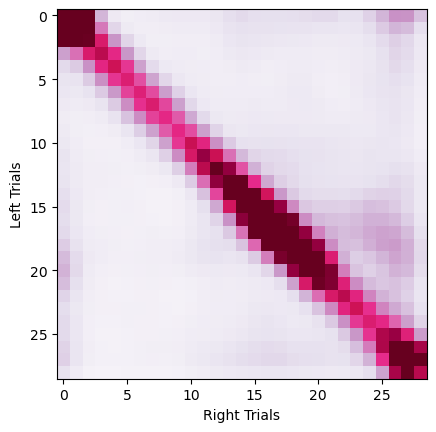

In [42]:
day = 5

ctrl_hist_sm = 0
for mouse in ctrl_mice:
    ctrl_hist_sm += get_smooth_hist(np.argmax(ctrl_left_mats[mouse][day],axis=0), np.argmax(ctrl_right_mats[mouse][day],axis=0))
ctrl_hist_sm /= len(ctrl_mice)
ctrl_hist_sm /= ctrl_hist_sm.ravel().sum()

fig,ax = plt.subplots()
h = ax.imshow(ctrl_hist_sm,vmin=0,vmax=.005, cmap = 'PuRd')
ax.set_ylabel("Left Trials")
ax.set_xlabel("Right Trials")
ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
plt.colorbar(h,ax = ax)
# fig.savefig(os.path.join(figdir,"ctrl_lr_remap_hist_day%d.pdf" % day),format='pdf')

ko_hist_sm = 0
for mouse in ko_mice:
    ko_hist_sm += get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0))
ko_hist_sm /= len(ko_mice)
ko_hist_sm /= ko_hist_sm.ravel().sum()

fig,ax = plt.subplots()
ax.imshow(ko_hist_sm,vmin=0,vmax=.005, cmap = 'PuRd')
ax.set_ylabel("Left Trials")
ax.set_xlabel("Right Trials")
ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
# fig.savefig(os.path.join(figdir,"ko_lr_remap_hist_day%d.pdf" % day),format='pdf')

fig,ax = plt.subplots()
h = ax.imshow(ctrl_hist_sm-ko_hist_sm,cmap='RdGy', vmin= -.002, vmax = .002)
ax.set_xlabel("Left Trials")
ax.set_ylabel("Right Trials")
ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
plt.colorbar(h,ax = ax)
# fig.savefig(os.path.join(figdir,"ko_v_ctrl_lr_remap_hist_day%d.pdf" % day),format='pdf')

NameError: name 'rz_early' is not defined

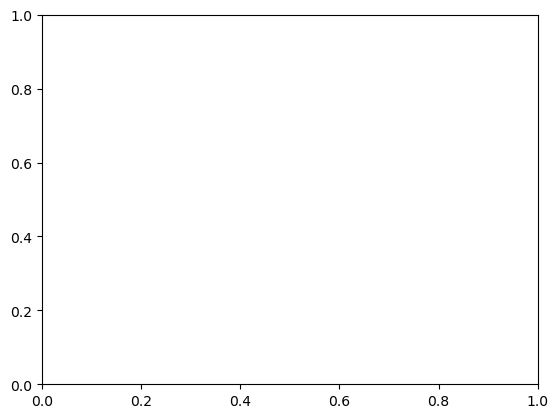

In [44]:
fig,ax = plt.subplots()

ctrl_reward_cells = np.zeros([6,len(ctrl_mice)])
ko_reward_cells = np.zeros([6,len(ko_mice)])

df = pd.DataFrame({'mouse':[],
                    'ko':[],
                    'day':[], 
                    'frac': [], 
                    })

for day in range(6):
    for m, mouse in enumerate(ctrl_mice):
        _hist = get_smooth_hist(np.argmax(ctrl_left_mats[mouse][day],axis=0), np.argmax(ctrl_right_mats[mouse][day],axis=0))
        frac = _hist[rz_early[0][0]-5:rz_early[0][0],rz_late[0][0]-5:rz_late[0][0]].sum(axis=-1).sum(axis=-1)
        ctrl_reward_cells[day,m] = frac
        df = pd.concat((df, pd.DataFrame({'mouse': m,
                        'ko': 0,
                        'day': day,
                        'frac': frac}, index=[len(df)])), ignore_index=True)
        
        
    for m, mouse in enumerate(ko_mice):
        _hist = get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0))
        ko_reward_cells[day,m] = _hist[rz_early[0][0]-5:rz_early[0][0],rz_late[0][0]-5:rz_late[0][0]].sum(axis=-1).sum(axis=-1)
        df = pd.concat((df, pd.DataFrame({'mouse': m+len(ctrl_mice),
                        'ko': 1,
                        'day': day,
                        'frac': frac}, index=[len(df)])), ignore_index=True)
    
for day in range(6):
    ax.scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), ctrl_reward_cells[day,:] , color = 'black', s=10)
    ax.plot(5*day  -1 + np.array([-0.2,0.2]), ctrl_reward_cells[day,:].mean()*np.ones([2,]), color='black', linewidth = 5, alpha = .3)
    
    ax.scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ko_mice)), ko_reward_cells[day,:] , color = 'red', s=10)
    ax.plot(5*day  +1 + np.array([-0.2,0.2]), ko_reward_cells[day,:].mean()*np.ones([2,]), color='red', linewidth = 5, alpha = .3)
    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("% of Cells")
ax.set_xticks(5*np.arange(6))
ax.set_xticklabels(np.arange(1,7))
ax.plot([-2.3, 27.3], ((5/20)**2)*np.ones((2,)), 'k--', zorder= -1, alpha=.5)


# fig.savefig(os.path.join(figdir,"reward_cell_summary.pdf"))
# ko_hist_sm = []
# for mouse in ko_mice:
#     ko_hist_sm.append(get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0)))

# ko_hist_sm = np.array(ko_hist_sm)
# ko_reward_cells = ko_hist_sm[:,rz_early[0][0]-5:rz_early[0][0]-1,rz_late[0][0]-5:rz_late[0][0]-1].sum(axis=-1).sum(axis=-1)

In [20]:
16/(30*30)

0.017777777777777778

In [21]:
res = pg.mixed_anova(data = df, dv= 'frac', between = 'ko', within = 'day', subject = 'mouse')
print(res)

posthoc = pg.pairwise_ttests(data = df, dv= 'frac', between = 'ko', within = 'day', subject = 'mouse', padjust='holm', parametric=True)
print(posthoc)

        Source        SS  DF1  DF2        MS          F         p-unc  \
0           ko  0.009659    1   14  0.009659  21.122244  4.156992e-04   
1          day  0.028052    5   70  0.005610  57.022507  2.467923e-23   
2  Interaction  0.003177    5   70  0.000635   6.458474  5.453582e-05   

        np2       eps  
0  0.601392       NaN  
1  0.802879  0.433039  
2  0.315687       NaN  
    Contrast  day    A    B Paired  Parametric          T   dof alternative  \
0        day    -  0.0  1.0   True        True  -6.532290  15.0   two-sided   
1        day    -  0.0  2.0   True        True  -9.304382  15.0   two-sided   
2        day    -  0.0  3.0   True        True  -9.375215  15.0   two-sided   
3        day    -  0.0  4.0   True        True  -8.818570  15.0   two-sided   
4        day    -  0.0  5.0   True        True -10.384189  15.0   two-sided   
5        day    -  1.0  2.0   True        True  -5.246995  15.0   two-sided   
6        day    -  1.0  3.0   True        True  -6.341935 

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.product(eig) / (eig.sum() / d) ** d
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the 

(6, 9) (6, 7)
3.3343135813572675 0.0008551019694724832


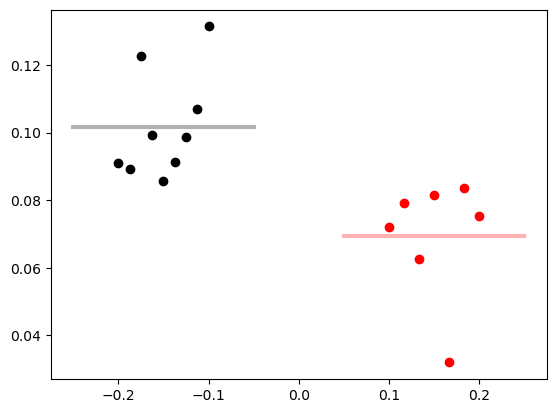

In [22]:
print(ctrl_reward_cells.shape, ko_reward_cells.shape)
t,p = sp.stats.ranksums(ctrl_reward_cells[-1,:], ko_reward_cells[-1,:])
print(t,p)

fig,ax = plt.subplots()
ax.scatter(np.linspace(-.2,-.1,num=len(ctrl_mice)), ctrl_reward_cells[-1,:], color= 'black')
ax.plot(np.array([-.25,-.05]), ctrl_reward_cells[-1,:].mean()*np.ones([2,]),color='black', alpha=.3,linewidth=3)
ax.scatter(np.linspace(.1,.2,num=len(ko_mice)), ko_reward_cells[-1,:], color= 'red')
ax.plot(np.array([.05,.25]), ko_reward_cells[-1,:].mean()*np.ones([2,]),color='red', alpha=.3,linewidth=3)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 's

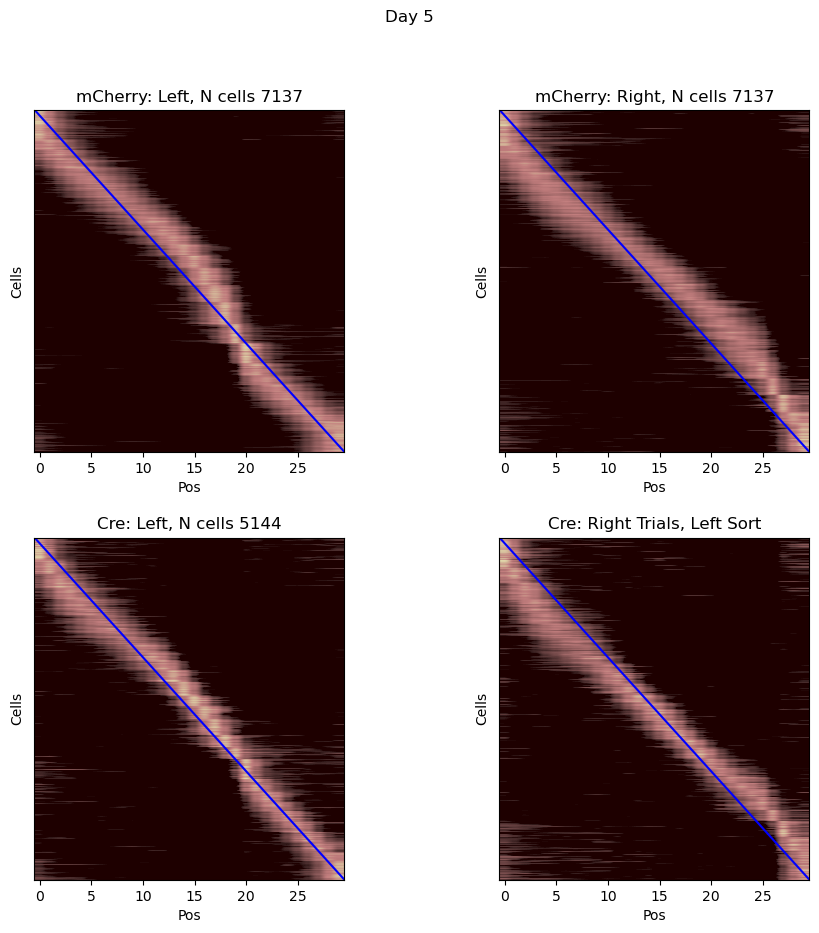

In [26]:
for day in range(5,6):
    fig,ax = stx.reward_overrep.plot_leftright_crossval_placecells_withinday(day, ts_key = 'spks', vmin = 0, vmax=6)
    fig.savefig(os.path.join(figdir,"population_placecells_day%d.pdf" % day), format='pdf')